
<a id='kalman'></a>

# Пример использования фильтра Калмана


<a id='index-0'></a>

Задача состоит в оценке фирмой человеческого капитала и усилий работника.

Человеческий капитал - это набор навыков, опыта работника полезных в производстве продукта фирмой. В процессе работы сотрудник накапливает человеческий капитал.

Человеческий капитал и усилия работника ненаблюдаемы для фирмы. Тем не менее задача эффективного распределения оплаты труда (например, поощрять сотрудников, которые готовы развиваться на благо фирмы и производства против тех, кто этого не делает) является осмысленной.

Фирма создает своё впечатление об уровне человеческого капитала и усилиях работника наблюдая историю выпуска продукта. В процессе наблюдения фирма понимает взаимосвязь выпуска и человеческого капитала, в том числе как последний зависит от усилий работника.

Например, на основе своих наблюдений фирма может определять уровень заработной платы. В этой задаче мы его определим как некоторую функцию от наблюдаемого выпуска работника фирмой с учетом зависимости от человеческого капитала и усилий сотрудника.

In [34]:
#pip install latex

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from scipy.stats import multivariate_normal
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

## Задача работника

Положим, что сотрудник фирмы имеет пожизненный контракт.
Мы можем описать выпуск, который работник производит при помощи следующих уравнений:

$$
\begin{aligned}
h_{t+1} &= \alpha h_t + \beta u_t + w_{t+1}, \quad w_{t+1} \sim {\mathcal N}(0,С) \\
u_{t+1} & = u_t \\
x_t & = g h_t + v_t , \quad v_t \sim {\mathcal N} (0, R)
\end{aligned} \tag{1}
$$

где

- $ h_t $ - это логарифм человеческого капитала в момент времени $ t $  
- $ u_t $ - это логарифм усилий работника при человеческом капитале (желание работника прогрессировать в своей работе при текущем уровне компетенций) в момент времени $ t $  
- $ x_t $ - это логарифм выпуска работника (например, количество произведенных станков) в момент времени $ t $  
- $ h_0 \sim {\mathcal N}(\hat h_0, \sigma_{h,0}) $  
- $ u_0 \sim {\mathcal N}(\hat u_0, \sigma_{u,0}) $  

Отступление:

Постановка задачи пришла из экономики и неподготовленному читателю может быть непривычно появление логарифмов. Экономисты любят использовать в качестве производственной функции, описывающей выпуск фирмы, функцию Кобба-Дугласа: 

$$
\begin{aligned}
Y &= K^a H^b (AL)^{(1-a-b)} 
\end{aligned}
$$

где

- $ K $ - это капитал фирмы (заводы, производственные линии и т.д.)
- $ H $ - это человеческий капитал работников
- $ A $ - уровень технологического прогресса (некоторая ненаблюдаемая переменная, которая характеризует технологический прогресс)
- $ L $ - труд рабочих (сколько трудочасов нужно для производства продукта)

$ a, b $ - параметры

Обратите внимание, что при помощи логарифмирования такая функция превращается в линейную относительно логарифмов факторов производства.

Конец отступления

Таким образом, параметры модели: $ \alpha, \beta, С, R, g, \hat h_0, \hat u_0, \sigma_h, \sigma_u $.

В момент времени $ 0 $ фирма наняла работника. Т.к. у работника пожизненный контракт, то он работает на фирмы все моменты времени $ t =0, 1, 2, \ldots $.

В момент времени $ 0 $ фирма не наблюдает ни начальный уровень человеческого капитала работника $ h_0 $, ни его уровень усилий $ u_0 $. Фирме нужно проверить работника в деле, чтобы адекватно оценить его полезность в производстве продукта.

Фирма верит, что $ u_0 $ для конкретного работника реализуется из нормального распределения $ u_0 \sim {\mathcal N}(\hat u_0, \sigma_{u,0}) $.

Человеческий капитал внутри фирмы конкретного работника может меняться во времени $ h_t $, но уровень его усилий будем считать постоянным  $ u_t = u_0 $. Здесь мы полагаем, что привычки человека сложно изменимы, например, если человек прокрастинатор, то эта черта с ним останется. Ровно как и если человек трудяга, то скорее всего он им и останется.

Получается, что с позиции фирмы уровень усилий работника для накапливания человеческого капитала является константой (некоторым фиксированным параметром).

В момент времени $ t\geq 1 $ для конкретного работника фирма наблюдает его выпуск  $ x^{t-1} = [x_{t-1}, x_{t-2}, \ldots, x_0] $.

Фирма не знает (не наблюдает) тип работника (его характеристики) $ (h_0, u_0) $.

Фирма наблюдает выпуск работника $ x_t $ и помнит как он работал в прошлые периоды $ x^{t-1} $.


## Политика фирмы по назначению заработной платы

В описанном мире можно задать правило, по которому фирма решает сколько платить работнику. Фирма опирается на уровень выпуска, который в свою очередь зависит от характеристик работника. Таким образом, в момент времени $ t \geq 1 $, фирма платит логарифм зарплаты:
$$
W_t = g  E [ h_t | x^{t-1} ], \quad t \geq 1
$$

Заработная плата пропорциональна ожиданиям фирмы относительно успешности / усердности работника.

В момент времени $ 0 $ фирма платит работнику:

$$
W_0 = g \hat h_0
$$

При таком зарплатном правиле, фирма учитывает, что выпуск работника частично зависит от его человеческого капитала, т.к. разумно предположить, что есть и иные факторы (помощь коллег, подмена на смене и др. события), которые могут влиять. Они описаны при помощи случайной компоненты $ v_t $ независимой от $ h_t $ и $ u_t $.

## Матричное представление описанной модели

Перепишем систему (1) в матричном виде:

$$
\begin{aligned}
\begin{bmatrix} h_{t+1} \cr u_{t+1} \end{bmatrix} &= \begin{bmatrix} \alpha & \beta \cr 0 & 1 \end{bmatrix}\begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} + \begin{bmatrix} 1 \cr 0 \end{bmatrix} w_{t+1} \cr
x_t & = \begin{bmatrix} g & 0 \end{bmatrix} \begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} + v_t
\end{aligned}
$$

что эквивалентно представлению задачи фильтра Калмана:

$$
\begin{aligned} 
y_{t+1} & = A y_t + w_{t+1} \cr
x_t & = B y_t + v_t \cr
y_0 & \sim {\mathcal N}(\hat y_0, \Sigma_0) \cr 
w_{t} &\sim {\mathcal N}(0,C) \cr
v_t & \sim {\mathcal N} (0, R)\cr
\end{aligned} \tag{2}
$$

где

$$
y_t  = \begin{bmatrix} h_{t} \cr u_{t} \end{bmatrix} , \quad \mu_0 = \begin{bmatrix} \hat h_0 \cr \hat u_0 \end{bmatrix}, \quad \Sigma_0  = \begin{bmatrix} \sigma_{h,0} & 0 \cr
                     0 & \sigma_{u,0} \end{bmatrix}, \quad
y_0  \sim {\mathcal N}( \mu_0, \Sigma_0), \quad

$$


Попробуем оценить зарплатную политику фирмы, сначала создав "работника":

In [36]:
WorkerModel = namedtuple("WorkerModel", 
                ('A', 'Ry', 'B', 'Rx', 'yhat_0', 'sigma_0'))

def create_worker(alpha=.8, beta=.2, C=.2,
                  R=.5, g=1.0, hhat_0=4, uhat_0=4, 
                  sigma_h=4, sigma_u=4):
    
    A = np.array([[alpha, beta], 
                  [0, 1]])
    
    # Здесь не совсем ковариационная матрица
    # Но класс фильтра не даёт указать явно матрицу перед w_{t+1}
    # Поэтому для u_t будет нулевая дисперсия.
    Ry = np.array([[C, 0], 
                  [0, 0]])
    
    # Добиваем размерности до двух
    B = np.array([g, 0])[None,:]

    Rx = np.array([[R]])

    # Define initial state and covariance matrix
    yhat_0 = np.array([[hhat_0], 
                       [uhat_0]])
    
    sigma_0 = np.array([[sigma_h, 0],
                    [0, sigma_u]])
    
    return WorkerModel(A=A, Ry=Ry, B=B, Rx=Rx, yhat_0=yhat_0, sigma_0=sigma_0)

In [37]:
from kalmanlib import LinearGaussianSignalGenerator, KalmanFilter

In [38]:
worker = create_worker()
A, Ry, B, Rx = worker.A, worker.Ry, worker.B, worker.Rx
yhat_0, sigma_0 = worker.yhat_0, worker.sigma_0


gen = LinearGaussianSignalGenerator(A=A, B=B, Ry=Ry, Rx=Rx)

Создадим симуляцию работы сотрудника $ \{x_t, y_t\} $ 


In [39]:
T = 100

# Можно взять стартовую точку фиксированную
# Либо посэмплировать из некоторого распределения как в определении задачи

start = np.random.multivariate_normal(mean=yhat_0.ravel(), cov=sigma_0)
# start=yhat_0.ravel()

y, x = gen.generate(N=T, start=start)
u_0 = y[1, 0]


In [40]:
# На самом деле стартовую точку можно взять более-менее любую, даже далеко от начала генерации
# Этот bias чисто для примера, что фильтр в целом справится, 
# Хотя при очень большом сдвиге в начале фильтрованной последовательности будет искажение
# Попробуйте bias = 0 и 10
bias = 1
filter = KalmanFilter(A=A, B=B, Ry=Ry, Rx=Rx, startMean=yhat_0.ravel()+bias, startCov=sigma_0+bias)

signal, errors, apr_signal,apr_errors = filter.filterSignal(x)
smoothedSig, smoothedErrs = filter.smoothSignal(signal,errors,apr_signal,apr_errors)

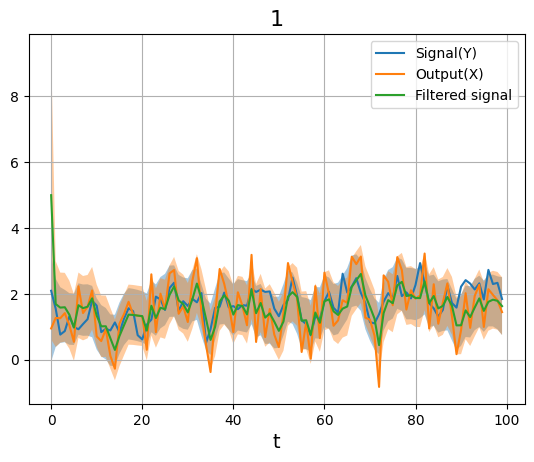

In [41]:
fig= plt.figure()

plt.grid()
plt.title("1", fontsize=16)
plt.xlabel("t", fontsize=14)
plt.plot(np.arange(T), y[0].ravel())
plt.plot(np.arange(T), x[0].ravel())
plt.plot(np.arange(T), signal[0,:])
# plt.plot(np.arange(T), smoothedSig[0,:])
plt.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
plt.fill_between(np.arange(T),signal[0,:]-1.96*np.sqrt(errors[0,0,:]), signal[0,:]+1.96*np.sqrt(errors[0,0,:]), alpha=0.4 )

plt.legend(["Signal(Y)","Output(X)","Filtered signal"])
# plt.legend(["Signal(Y)","Output(X)","Filtered signal","Smoothed signal"])

# plt.savefig('filtered.pdf')
plt.show()

Для начальных условий $ h_0, u_0 $,  нарисуем $ E x_t = G \hat y_t $, где $ \hat y_t = E [y_t | x^{t-1}] $.

Также изобразим $ E [u_0 | x^{t-1}] $, где фирма составляет свое представление об усилии работника  $ u_0 $ опираясь на историю его продуктивности  $ x^{t-1} $ известную фирме в момент времени $ t $.

Видно, что представление фирмы  $ E [u_0 | x^{t-1}] $ об усилии работника сходится к начальному значению $ u_0 $, которое на самом деле фирмой не наблюдается. Если сходимости не видно на графике, увеличьте T до 1000.

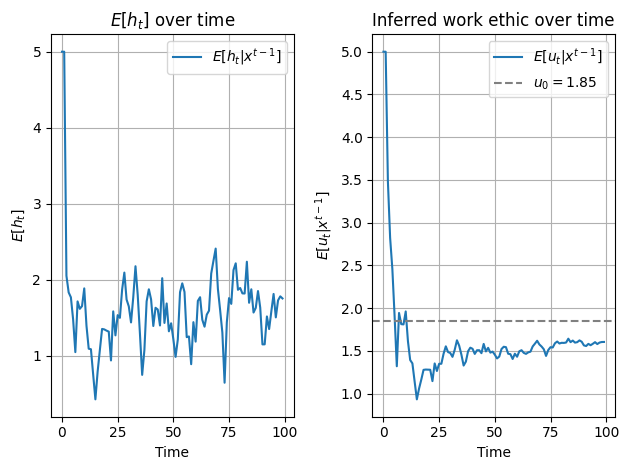

In [42]:
fig, ax = plt.subplots(1, 2)

ax[0].grid()
ax[0].plot(apr_signal[0].ravel(), label=r'$E[h_t| x^{t-1}]$')
ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$E[h_t]$')
ax[0].set_title(r'$E[h_t]$ over time')
ax[0].legend()

ax[1].grid()
ax[1].plot(apr_signal[1].ravel(), label=r'$E[u_t|x^{t-1}]$')
ax[1].axhline(y=u_0, color='grey', 
            linestyle='dashed', label=fr'$u_0={u_0:.2f}$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$E[u_t|x^{t-1}]$')
ax[1].set_title('Inferred work ethic over time')
ax[1].legend()

fig.tight_layout()
plt.show()

## Полезный вычислительный эксперимент

Обратим внимание на параметры  $ \Sigma_0 $ and $ \Sigma_T $, чтобы посмотреть как фирма обучается на заданном горизонте времени:

In [43]:
print(apr_errors[:, :, 0])

[[5. 1.]
 [1. 5.]]


In [44]:
print(apr_errors[:, :, -1])

[[0.33493306 0.02205033]
 [0.02205033 0.05688594]]


Видим, что значения в условной ковариационной матрице со временем уменьшаются

Динамику $ \Sigma_t $ можно увидеть через изображение гауссиан вокруг $ E [y_t |x^{t-1}] $ в различные моменты времени $ t $.

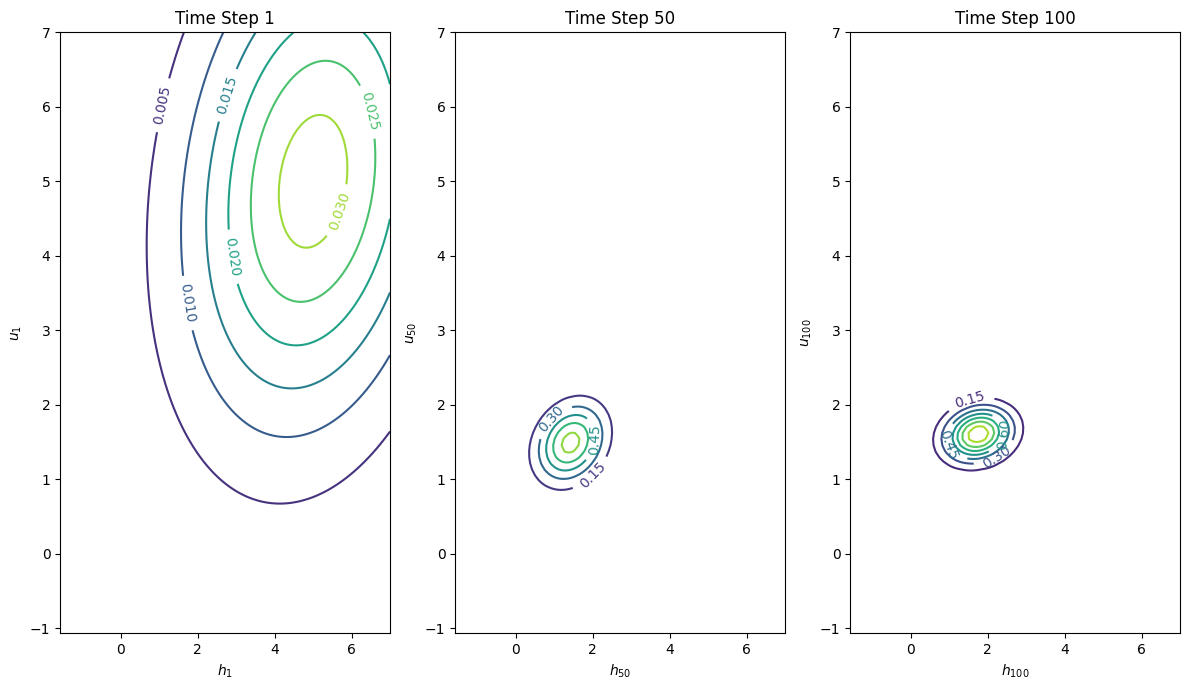

In [45]:
# Create a grid of points for contour plotting
h_range = np.linspace(apr_signal[0, :].min()-0.5*sigma_0[0, 0], 
                      apr_signal[0, :].max()+0.5*sigma_0[0, 0], 100)
u_range = np.linspace(apr_signal[1, :].min()-0.5*sigma_0[1, 1], 
                      apr_signal[1, :].max()+0.5*sigma_0[1, 1], 100)
h, u = np.meshgrid(h_range, u_range)

# Create a figure with subplots for each time step
fig, axs = plt.subplots(1, 3, figsize=(12, 7))

# Iterate through each time step
for i, t in enumerate(np.linspace(0, T-1, 3, dtype=int)):
    # Create a multivariate normal distribution with x_hat and Σ at time step t
    mu = apr_signal[:, t]
    cov = apr_errors[:, :, t]
    mvn = multivariate_normal(mean=mu, cov=cov, allow_singular=True)
    
    # Evaluate the multivariate normal PDF on the grid
    pdf_values = mvn.pdf(np.dstack((h, u)))
    
    # Create a contour plot for the PDF
    con = axs[i].contour(h, u, pdf_values, cmap='viridis')
    axs[i].clabel(con, inline=1, fontsize=10)
    axs[i].set_title(f'Time Step {t+1}')
    axs[i].set_xlabel(r'$h_{{{}}}$'.format(str(t+1)))
    axs[i].set_ylabel(r'$u_{{{}}}$'.format(str(t+1)))
    
    #cov_latex = r'$$\Sigma_{{{}}}= \\begin{{bmatrix}} {:.2f} & {:.2f} \\\\ {:.2f} & {:.2f} \\end{{bmatrix}}$$'.format(
    #    t+1, cov[0, 0], cov[0, 1], cov[1, 0], cov[1, 1]
    #)
    #axs[i].text(0.33, -0.15, cov_latex, transform=axs[i].transAxes)

    
plt.tight_layout()
plt.show()

Накопление наблюдений за выпуском работника $ x^t $ сужает доверительные интервалы дисперсии с ростом времени $ t $.